In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

#### LockUp Tables

In [2]:
digitsOfSymbolAtAdmiralMarket = { "GOLD" : 3,"SILVER" : 3,"WTI" : 2,"CRUDOIL" : 2,'NGAS': 3,"BRENT" : 2,"[CAC40]":2,
            "[TECDAX30]":2,"[DAX30]":2,
            "[DJI30]":2,"[FTSE100]":2,"[HSCEI50]":1,"[HSI50]":2,"[JP225]":2,"[NQ100]":2,"[UK100]":2,"[SP500]":2,"BTCUSD":2,
            "AUDCAD" : 5,"AUDCHF" : 5,"AUDJPY" : 3,"AUDNZD" : 5,"AUDUSD" : 5,"CADCHF" : 5,"CADJPY" : 3,"CHFJPY" : 3,"EURAUD" : 5,
            "EURCAD" : 5,"EURCHF" : 5,"EURCZK" : 4,"EURGBP" : 5,"EURHUF" : 3,"EURJPY" : 3,"EURNZD" : 3,"EURPLZ" : 5,"EURRUB" : 5,
            "EURUSD" : 5,"GBPAUD" : 5,"GBPCAD" : 5,"GBPCHF" : 5,"GBPJPY" : 3,"GBPNZD" : 5,"GBPUSD" : 5,"NZDCAD" : 5,"NZDCHF" : 5,
            "NZDJPY" : 3,"NZDUSD" : 5,"USDBRL" : 4,"USDCAD" : 5,"USDCHF" : 5,"USDCLP" : 2,"USDCNH" : 4,"USDCZK" : 4,"USDJPY" : 3,
            "USDHUF" : 4,"USDMXN" : 5,"USDPLZ" : 5,"USDRON" : 5,"USDRUB" : 5,"USDNOK" : 5,"USDTRY" : 5,"USDZAR" : 5}
def convertSymbolName(tmpSymbol):
    lockup = { "XAUUSD" : "GOLD", "AUXUSD": "SILVER", "SPXUSD" : "[SP500]", "JPXJPY": "[JP225]", "NSXUSD": "[NQ100]",
               "UKXGBP": "[FTSE100]", "GRXEUR": "[DAX30]", "HKXHKD": "[HSI50]","WTIUSD":"WTI", "BCOUSD":"CRUDOIL", "ETXEUR":"EUROSTOXX"}
    return lockup.get(tmpSymbol, tmpSymbol)

# Import File

In [3]:
year = '2019'
symbol = 'WTIUSD'
#decimalDigits is Broker Specific and need lookUpTable 
amountDecimalDigits = digitsOfSymbolAtAdmiralMarket[convertSymbolName(symbol)]

path = './Data/'
filename = '/DAT_MT_'+symbol+'_M1_2019.csv'
print(path+filename)
filePath= path+filename
df = pd.read_csv(filePath,header=0)
df=df.round(amountDecimalDigits)


./Data//DAT_MT_WTIUSD_M1_2019.csv


# Generate DataFrames in M1 M5 M15 M30 H1 H4

In [5]:
#delete column 'volume'
df = df.drop('volume',axis='columns')
#join column 'time'&&'date' in 'fulltime'
df['fulltime'] = pd.to_datetime(df['date']+' '+df['time'])
#drop column 'time'&&'date'
df.drop(['date','time'], axis = 1, inplace=True)
#rename column 'fulltime' -> 'time'
df.rename({'fulltime':'time'}, axis = 'columns',inplace=True)
#set column 'time' from type array to datetime
df['time'] = pd.to_datetime(df['time'])
#set column 'time' to index
df = df.set_index('time')

#calculate dataframe M1 M5 M15 M30 H1 H4
dataframe = symbol+'_'+year+'_'

dataframe_M1= df
dataframe_M5 = df.resample('5Min').agg({'open': 'first', 
                                 'high': 'max', 
                                 'low': 'min', 
                                 'close': 'last'})
dataframe_M15 = df.resample('15Min').agg({'open': 'first', 
                                 'high': 'max', 
                                 'low': 'min', 
                                 'close': 'last'})
dataframe_M30 = df.resample('30Min').agg({'open': 'first', 
                                 'high': 'max', 
                                 'low': 'min', 
                                 'close': 'last'})
dataframe_H1 = df.resample('60Min').agg({'open': 'first', 
                                 'high': 'max', 
                                 'low': 'min', 
                                 'close': 'last'})
dataframe_H4 = df.resample('240Min').agg({'open': 'first', 
                                 'high': 'max', 
                                 'low': 'min', 
                                 'close': 'last'})



### in DataFrames add column 'deltaPips'
##### deltaPips = high - low

In [6]:
allDataFrames =  [dataframe_M1,dataframe_M5,dataframe_M15,dataframe_M30,dataframe_H1,dataframe_H4]
for buff in allDataFrames:
    buff.dropna(inplace=True)
    buff['deltaPips'] = pd.eval(('buff.high-buff.low'))
    buff['deltaPips'] = buff['deltaPips'] *1 *10 ** amountDecimalDigits
    buff['deltaPips'] = buff['deltaPips'].astype(int)


## Calculate Percentiles
#### Percentile 80%, 95% calculated
#### all 'deltaPips' values  above the 95% percentile are converted to " 95% percentile 'deltaPip' value"+1

In [10]:
#hist_M1 = dataframe_M1['deltaPips'].hist(bins=2935)
#['M1',dataframe_M1['deltaPips'].describe(percentiles=[0.25,0.5,0.75,0.8,0.9,0.95,1])]
# get values of describe() in variable
describe_M1 = dataframe_M1['deltaPips'].describe(percentiles=[0.25,0.5,0.75,0.8,0.9,0.95,1])
# save value of 95 percentile in value
hist_M1_value_percentile_95 = round(describe_M1['95%'])
hist_M1_value_percentile_80 = round(describe_M1['80%'])
#drop NA
dataframe_M1_95percentile = dataframe_M1.dropna()
# convert float to int
dataframe_M1_95percentile['deltaPips'] = np.int32(dataframe_M1['deltaPips'])
# write all value > 95% percentile into one candleSize => percentile_95 +1
dataframe_M1_95percentile['deltaPips'] = dataframe_M1['deltaPips'].apply( lambda x: hist_M1_value_percentile_95+1 if x > hist_M1_value_percentile_95 else x)


######################################################################################################################
#Prepare Data for M5 DataFrame
######################################################################################################################
describe_M5 = dataframe_M5['deltaPips'].describe(percentiles=[0.25,0.5,0.75,0.8,0.9,0.95,1])
# save value of 95 percentile in value
hist_M5_value_percentile_95 = round(describe_M5['95%'])
hist_M5_value_percentile_80 = round(describe_M5['80%'])

#drop NA
dataframe_M5_95percentile = dataframe_M5.dropna()
# convert float to int
dataframe_M5_95percentile['deltaPips'] = np.int64(dataframe_M5_95percentile['deltaPips'])
# write all value > 95% percentile into one candleSize => percentile_95 +1
dataframe_M5_95percentile['deltaPips'] = dataframe_M5_95percentile['deltaPips'].apply( lambda x: hist_M5_value_percentile_95+1 if x > hist_M5_value_percentile_95 else x)

######################################################################################################################
#Prepare Data for M30 DataFrame
######################################################################################################################
describe_M30 = dataframe_M30['deltaPips'].describe(percentiles=[0.25,0.5,0.75,0.8,0.9,0.95,1])
# save value of 95 percentile in value
hist_M30_value_percentile_95 = round(describe_M30['95%'])
hist_M30_value_percentile_80 = round(describe_M30['80%'])

#drop NA
dataframe_M30_95percentile = dataframe_M30.dropna()
# convert float to int
dataframe_M30_95percentile['deltaPips'] = np.int32(dataframe_M30_95percentile['deltaPips'])
# write all value > 95% percentile into one candleSize => percentile_95 +1
dataframe_M30_95percentile['deltaPips'] = dataframe_M30_95percentile['deltaPips'].apply( lambda x: hist_M30_value_percentile_95+1 if x > hist_M30_value_percentile_95 else x)



######################################################################################################################
#Prepare Data for H1 DataFrame
######################################################################################################################
describe_H1 = dataframe_H1['deltaPips'].describe(percentiles=[0.25,0.5,0.75,0.8,0.9,0.95,1])
# save value of 95 percentile in value
hist_H1_value_percentile_95 = round(describe_H1['95%'])
hist_H1_value_percentile_80 = round(describe_H1['80%'])

#drop NA
dataframe_H1_95percentile = dataframe_H1.dropna()
# convert float to int
dataframe_H1_95percentile['deltaPips'] = np.int32(dataframe_H1_95percentile['deltaPips'])
# write all value > 95% percentile into one candleSize => percentile_95 +1
dataframe_H1_95percentile['deltaPips'] = dataframe_H1_95percentile['deltaPips'].apply( lambda x: hist_H1_value_percentile_95+1 if x > hist_H1_value_percentile_95 else x)

# Generate Plot mit Bokeh
### generate histogram for M1 M5 M15 M30 H1 H4
### plot all histograms in one view

In [11]:
#['M1',dataframe_M1['deltaPips'].describe(),'M5',dataframe_M5['deltaPips'].describe(),'M15',dataframe_M15['deltaPips'].describe(),'M30',dataframe_M30['deltaPips'].describe(),'H1',dataframe_H1['deltaPips'].describe(),'H4',dataframe_H4['deltaPips'].describe()]

In [12]:
import scipy.special

from bokeh.layouts import gridplot
from bokeh.plotting import figure, output_file, show
from bokeh.io import curdoc, show
from bokeh.models import ColumnDataSource, Grid, Line, LinearAxis, Plot


def make_plot(title, hist, edges, position_vline):
    p = figure(title=title, tools='', background_fill_color="#fafafa")
    p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:],
           fill_color="navy", line_color="white")
    p.line([position_vline,position_vline], [0,max(hist)*0.2], line_color="orange", line_width=2, legend_label="80%_percentile at\n"+str(position_vline)+" pips")
    p.y_range.start = 0
    p.legend.location = "center_right"
    p.legend.background_fill_color = "#fefefe"
    p.xaxis.axis_label = 'Candle Size ( Valmax-Valmin in respective Timeframe)'
    p.yaxis.axis_label = 'Counts'
    p.grid.grid_line_color="white"
    return p

####################################################
# M1 hist

plotname = symbol +" " +year +" M1" 

measured =  dataframe_M1_95percentile['deltaPips']
edges_improved = np.histogram_bin_edges(measured, bins="auto")


hist, edges = np.histogram(measured,bins= edges_improved, density=False)

hist_M1 = make_plot(plotname, hist, edges,hist_M1_value_percentile_80)

#possible bins > rice scott doane fd sqrt auto
####################################################
# M5 hist

plotname = symbol +" " +year +" M5" 

measured =  dataframe_M5_95percentile['deltaPips']
edges_improved = np.histogram_bin_edges(measured, bins="sqrt")

hist, edges = np.histogram(measured, bins= edges_improved,  density=True)
hist_M5 = make_plot(plotname, hist, edges,hist_M5_value_percentile_80)

####################################################
# M30 hist

plotname = symbol +" " +year +" M30" 

measured =  dataframe_M30_95percentile['deltaPips']
edges_improved = np.histogram_bin_edges(measured, bins="sqrt")
hist, edges = np.histogram(measured, bins= edges_improved, density=False,)
hist_M30 = make_plot(plotname, hist, edges, hist_M30_value_percentile_80)

####################################################
# H1 hist

plotname = symbol +" " +year +" H1" 


measured =  dataframe_M30_95percentile['deltaPips']

edges_improved = np.histogram_bin_edges(measured, bins="sqrt")
hist, edges = np.histogram(measured, density=False, bins= edges_improved)
#hist, edges = np.histogram(measured, density=False, bins= hist_H1_value_percentile_95)
hist_H1 = make_plot(plotname, hist, edges, hist_H1_value_percentile_80)


#######################################################################################
output_file('Candlesizes_'+symbol+'_'+year+'.html', title="Candelesize in dependency of Timeframes.py example")

show(gridplot([hist_M1,hist_M5,hist_M30,hist_H1], ncols=2, plot_width=800, plot_height=400, toolbar_location=None))
#https://towardsdatascience.com/data-visualization-with-bokeh-in-python-part-one-getting-started-a11655a467d4

#### Bonus: Histogramm by MathPlot

NameError: name 'Text' is not defined

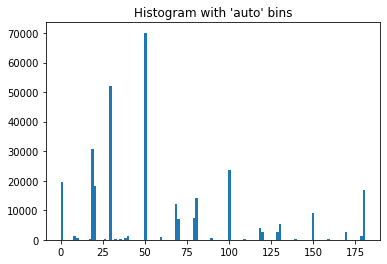

In [347]:
# matplot histogram
_ = plt.hist(dataframe_M1_95percentile['deltaPips'], bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
Text(0.5, 1.0, "Histogram with 'auto' bins")
plt.show()

#### Bonus: Histogram by Pandas

count    308354.000000
mean         60.975074
std          47.757549
min           0.000000
25%          29.000000
50%          50.000000
75%          80.000000
80%         100.000000
90%         130.000000
95%         180.000000
100%        181.000000
max         181.000000
Name: deltaPips, dtype: float64

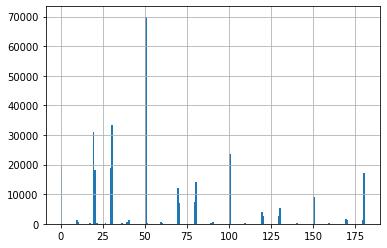

In [348]:
hist_M1_95percentile = dataframe_M1_95percentile['deltaPips'].hist(bins=hist_M1_value_percentile_95+1)
dataframe_M1_95percentile['deltaPips'].describe(percentiles=[0.25,0.5,0.75,0.8,0.9,0.95,1])

#### development Protocol

issues 
Get Histogram
-use bokeh and numpy.histogram
Show histogram for datasets with numbers > 1000 
automatisation